## Introduction

In this clustering section I hope to use features about patterns such as yardage, gauge, and needle sizes to understand groupings of patterns that go beyond type. My main reason for this is that I am curious about subgenres of patterns such as hats and mitts for instance which may use similar needle sizes or amounts of yarn. These categories can not be seen simply through comparison as there is likely to be a lot of overlap so I hope that utilizing clustering will help me visualize these subgroups. This may also give a value I can feed back into my naive bayes tab for improved predictive capability.

For more of my feature data I am going to keep things simple and use three dimensions with the size of needles visually on one axis visually, the average yardage of yarn on the other, and then yarn weight as the size of points. This will make it easier to visualize differences and I know from previous feature selection tests these variables would cover the most important aspects of the pattern. I will be keeping track of the type of pattern to use as comparison in final visualizations.

## Theory

I will be trying out a variety of clustering methods to see which is able to capture the structure of the data best. The methods will be detailed out below for reference.

#### K-Means Clustering

K-means clustering is a centroid based method which endeavors to group a dataset into n clusters with each data point being attributed to the nearest centroid. The process is iterative: a centroid is chosen at random to start, points are group by closeness to each centroid, the centroids are recalculated using the mean of the established clusters, and the whole process is repeated starting at the second step and looping until there is minimal difference from one loop to the next. The goal is to minimize the within-cluster variances which is done when calculating the squared euclidean distance between each point and the centroid.

This approach works best for best for a gaussian data distribution although it can work at clustering in other cases. It's an iterative approach and there may be some behavior determined by the random initial centroids so It's important to run a few cases to understand the distribution. Additionally, you can adjust the amount of initial centroids and visualize which number of clusters minimizes that within-cluster variance. The algorithm works best with some trial and error but is a strong and reliable method to compute clusters in the data.

#### DBSCAN
DBSCAN, in contrast to K-means, is a density based method that checks for density and proximity in the data rather than being centroid based. This type of method is very helpful when there are irregularities and outliers as they use location rather than mean to group. It works by grouping points which are neighbors and then chaining these points together when their intra-group distance is lower than the distance to other points. Unlike K-means, outliers are not included and can be left outside of the calculated groups.

DBSCAN is one of the more popular clustering methods and is well suited for non-linearly separated clusters. I'm unsure of the nature of my data so having a nonlinear option will be helpful when considering pattern density.

#### Hierarchical Clustering
Now, both of the previously discussed metrics are partitioning based; hierarchical models, in contrast, focus more on creating structures of groupings depending on the level of specificity required. The way it works is that starting either from the top (division) or bottom (agglomeration), groups are formed and then divided/combined level by level until you reach the opposite of what you started with, a group with all data points or a group for each data point. The overall concept is that, like decision trees, you can decide how deep the clustering could go and compare each 'level' to see which will be most useful for your data.

This method has its benefits and drawbacks. Like K-means, it can be tweaked roughly by number of groups and by structure while also being nested so that each grouping can be further analyzed by the sub groups within it. This can be a lot of information and the descriptive statistics to see which level is best can be complicated. However, this method proves to be a strong indicator for groups and groups within groups such that it would take multiples of other models to compete with its usefulness.

## Methods

I will be using the methods listed above, this includes k-means, dbscan, and hierarchical clustering. I'll do them in that order with some representations of the optimal groups and results shown later.

In [1]:
# importing all relevent libraries for clustering. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings('ignore')


#### Data Selection

I have already mentioned some of the features I will be using and so this is the process to get the variables into a data frame for analysis. I will not be using a feature selection test as I'm unsure of the reuslts I'm looking for, so instead I will limit the features to those best for visual analysis which were mentioned earlier.

In [12]:
pattern_df = pd.read_csv("../data/pattern_data_updated.csv")

pattern_df.columns


Index(['Unnamed: 0', 'comments_count', 'currency', 'price', 'currency_symbol',
       'free', 'published', 'difficulty_average', 'favorites_count',
       'projects_count', 'queued_projects_count', 'gauge', 'gauge_divisor',
       'gauge_pattern', 'row_gauge', 'id', 'name', 'permalink',
       'rating_average', 'rating_count', 'yardage', 'yardage_max',
       'yarn_weight_description', 'yarn_weight', 'needle_sizes_us',
       'needle_sizes_metric', 'hook_size', 'needle_sizes_name', 'craft',
       'pattern_type', 'pattern_desc', 'category_permalink',
       'category_parent_permalink', 'price_adjusted'],
      dtype='object')

In [13]:
yardage_average = pattern_df[["yardage","yardage_max"]].mean(axis = 1)

clustering_df = pattern_df[["needle_sizes_metric","yarn_weight_description"]]

X = pd.concat([clustering_df, yardage_average,pattern_df["pattern_type"]], axis = 1).dropna()

X.rename(columns = {0:"yardage_average"},inplace = True)

Y = X["pattern_type"]
X = X.drop("pattern_type",axis=1)

print(X.head())
print(Y.head())

   needle_sizes_metric  yarn_weight_description  yardage_average
0                 4.50                        3           1920.0
1                 2.75                        0           1210.0
2                 3.75                        4           1395.0
3                 5.50                        0           2025.5
4                 2.50                        3            683.5
0       other
1    pullover
2    pullover
3    pullover
4       scarf
Name: pattern_type, dtype: object


#### K-Means

I'll start with the K-means method, running an analysis and then visualizing based on the optimal hyperparameters.


   clusters  distortions      inertias
0         1   525.291772  3.758801e+10
1         2   255.033544  1.101013e+10
2         3   198.843836  5.770936e+09
3         4   154.831551  3.393179e+09
4         5   133.446701  2.368975e+09
5         6   101.753839  1.649563e+09
6         7    88.709757  1.205346e+09
7         8    79.986589  9.326244e+08
8         9    72.863267  7.557096e+08
9        10    67.987446  6.329259e+08


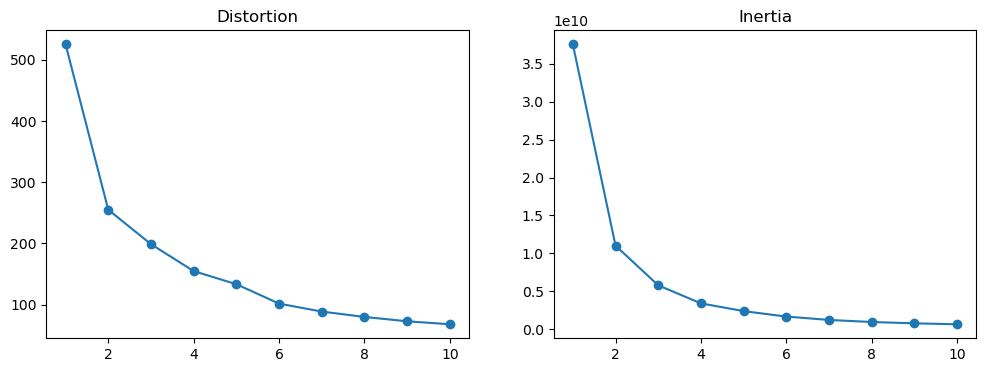

In [14]:
# Initializing some empty variables
clusters = []
distortions = []
inertias = []

# do all the clusters
for i in range(1,11):
    kmeans_inst = KMeans(n_clusters = i, random_state = 0)
    kmeans_inst.fit(X)
    clusters.append(i)
    centers_inst = kmeans_inst.cluster_centers_
    distortions.append(sum(np.min(pairwise_distances(X, centers_inst, metric='euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans_inst.inertia_)

## collecting the lists
df = pd.DataFrame({'clusters': clusters, 'distortions': distortions, 'inertias': inertias})

print(df)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))


ax[0].plot(df['clusters'], df['distortions'], marker='o')
ax[0].set_title('Distortion')

# Plot Inertia
ax[1].plot(df['clusters'], df['inertias'], marker='o')
ax[1].set_title('Inertia')

# Display the side-by-side plots
plt.show()

In [15]:
## Sources from this website: https://medium.com/nerd-for-tech/k-means-clustering-using-python-2150769bd0b9#:~:text=Distortion%20is%20the%20average%20sum,here%20can%20be%20Euclidean%20distance.

from kneed import KneeLocator
kl = KneeLocator(range(1, 11), df["inertias"], curve="convex", direction="decreasing")
kl.elbow

3

Looking at the graphs, there's a fall off after the first cluster and the elbow determiner gave 2 clusters as the optimal amount. I'll do a visualization of this grouping in the results section.

#### DBSCAN

For this process we are setting a min value amount as well as an epsilon amount in order to find a cluster which best suits the data. Since the dataset I'm using is fairly large the process becomes computationally costly, so to speed up the process I will just be using the stock amount of minimum values which is 5. This will cut down processing time and still hopefully allow for meaningful results.

    epsilons  top_clusters  best_silhouette
24       2.9            70         0.400891
23       2.8            68         0.392865
21       2.6            80         0.369742
22       2.7            75         0.366855
20       2.5            91         0.222975
7        1.2           514         0.002759
8        1.3           484         0.000691
9        1.4           478        -0.011884
17       2.2           122        -0.038180
16       2.1           123        -0.066233
5        1.0           599        -0.067475
14       1.9           194        -0.070816
6        1.1           562        -0.087972
18       2.3           103        -0.098506
3        0.8          1043        -0.128891
4        0.9          1043        -0.128891
19       2.4           100        -0.158127
2        0.7           949        -0.181661
1        0.6           947        -0.182431
10       1.5           321        -0.206129
0        0.5           910        -0.208966
15       2.0           150      

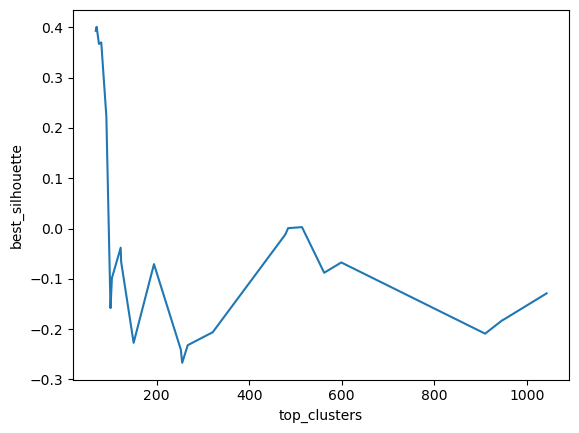

In [16]:
top_scores = []
epsilons = []
clusters = []

X2 = X.iloc[0:25000,:]
X2.shape

# setting list of density groups
dbs = [(i / 10) for i in range(5, 30)]

for i in dbs:
    max_score = -1
    best_cluster = -1
    best_eps = -1
    g = 5
    model = DBSCAN(eps=i, min_samples=g)
    predics = model.fit_predict(X2)
    num_clusters = len(pd.Series(predics).unique())
    if num_clusters > 1:
        score = silhouette_score(X2, predics)
        if score > max_score:
            max_score = score
            best_cluster = num_clusters
            best_eps = i
    top_scores.append(max_score)
    clusters.append(best_cluster)
    epsilons.append(best_eps)

db = pd.DataFrame({'epsilons': epsilons, 'top_clusters': clusters, 'best_silhouette': top_scores})
print(db.sort_values(by="best_silhouette", ascending=False))
sns.lineplot(data=db, 
             x='top_clusters',
             y='best_silhouette')
plt.show()

From the silhouette analysis, it seems that the silhouette score was highest at 63 clusters which is very different from the k-means conclusion so I'm interested in the comparison of the two.

#### Hierarchical Clustering

I'll run a similar hierarchical clustering model to find the optimal amount of clusters on the system.


In [17]:

sil_scores = []
clusters = []

for i in range(2,10):
    max_score = -1
    best_cluster = -1
    best_eps = -1
    hierarchical_cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward') 
    predics = hierarchical_cluster.fit_predict(X2)
    labels = hierarchical_cluster.labels_
    sil_scores.append(silhouette_score(X2,labels))
    clusters.append(i)
    

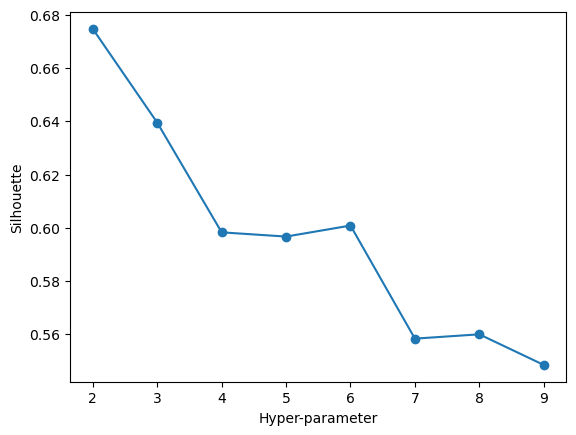

In [18]:
fig, ax = plt.subplots()
ax.plot(clusters, sil_scores, "-o")  
ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
plt.show()

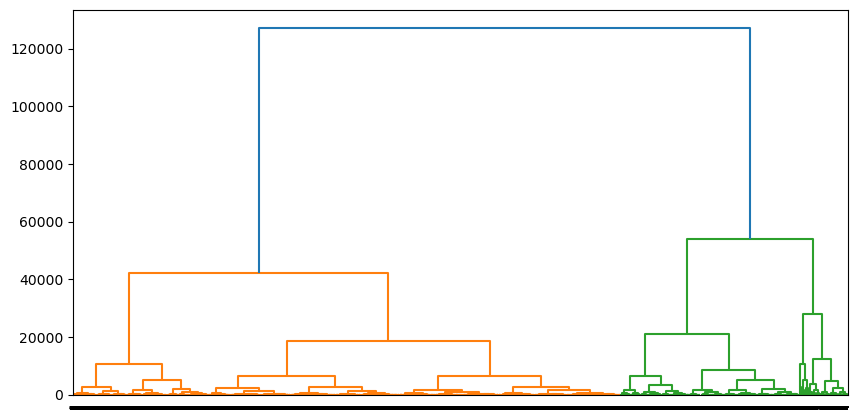

In [19]:
## I had too many data points for the model, so I will be shrinking it down to just 25000 data points
linkage_matrix = linkage(X.iloc[0:25000,:], method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, orientation='top', 
           labels=labels, 
           distance_sort='ascending', 
           show_leaf_counts=True
           )
plt.show()

It seems that 2-3 clusters represented the data best. While 2 clusters had a better score I will be using 3 to make it different from the k-means method.

## Results

So given the three methods we have a variety of optimal clusters which can give us some more information on the data. For K-means we had 2, DSBSCAN said 63, and Hierarchical Clustering gave 3. I'm unsure what this means about the data but I'm going to lead with visualization in order to see the clustering behavior in the data. I'm also going to continue to use the first 25,000 variables as my computer could not allocate the memory to run the models with all my data, but the amount given should be enough.


#### K-means

For Kmeans we had 2 clusters being optimal so let's see how that value reflects on the data.

<Axes: xlabel='needle_sizes_metric', ylabel='yardage_average'>

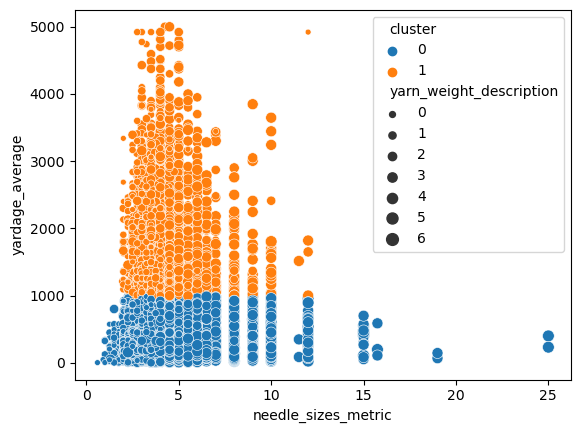

In [21]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(X2)
y_kmeans = kmeans.predict(X2)
X_kmeans = X2
X_kmeans['cluster'] = y_kmeans
X_kmeans.head()

sns.scatterplot(data =X_kmeans,
                x= "needle_sizes_metric",
                y = "yardage_average",
                size = "yarn_weight_description",
                hue = "cluster")



As expected from a two cluster data set, it seems the split does not help clarify too many groups. It does however show that patterns with more than roughly 1000 yards of fabric constitute their own group and have more in common with each other. This is reasonable as many of those patterns linger in the same range of needle size. I'm more impressed with how straight the clustering line is, it might be because the axes are uneven numerically.

#### DBSCAN

DBSCAN operates on density versus location so there may be more opportunities for subgroups in its analysis. since there are so many groups I'll be taking a subset of the subset to see if there is more of a gradient.

<Axes: xlabel='needle_sizes_metric', ylabel='yardage_average'>

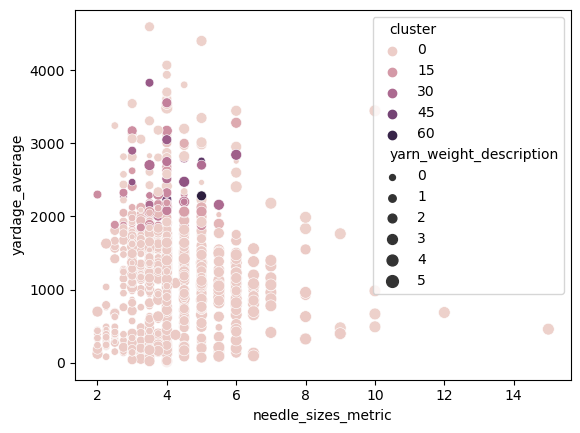

In [23]:
dbscan = DBSCAN(eps=2.9, min_samples=5)
dbscan.fit(X2)
y_dbscan = dbscan.labels_
X_dbscan = X2
X_dbscan['cluster'] = y_dbscan
X_dbscan.head()

sns.scatterplot(data =X_dbscan.iloc[0:1000,:],
                x= "needle_sizes_metric",
                y = "yardage_average",
                size = "yarn_weight_description",
                hue = "cluster")

The coloring of the subgroups is a gradient so it's harder to get a full sense of the behavior of all of the clusters but it can be seen that there are groupings of data points around the 2000-2500 yardage range which are highly correlated with each other. The rest of the data might have more nuance but it seems that most of the clustering data is in that range which is interesting.

There could be more to see here but there is the inverse problem of the K-means clustering which is too many clusters to really get a sense for things. It doesn't look awful but still isn't terribly helpful in understanding the nature of the data.

#### Hierarchical Clustering

Hierarchical clustering brings the optimal number of clusters down to 3 and I'm interested to see if it reflects the previous two clustering results.

<Axes: xlabel='needle_sizes_metric', ylabel='yardage_average'>

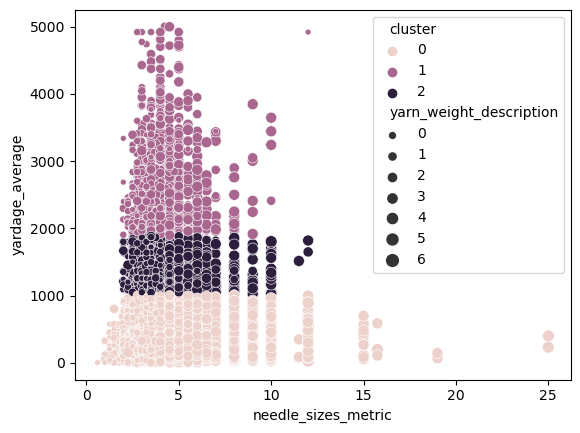

In [25]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward') 
hc.fit_predict(X2)
y_hc = hc.labels_
X_hc = X2
X_hc['cluster'] = y_hc
X_hc.head()

sns.scatterplot(data =X_hc,
                x= "needle_sizes_metric",
                y = "yardage_average",
                size = "yarn_weight_description",
                hue = "cluster")

In a way it does, this neapolitan ice cream stack reflects some of the density of the DBSCAN and the high low yardage split of the K-means. It shows the same information roughly that shorter, medium, and high yardage patterns all become groups of their own. I would like to note here that a pattern with over 1000 yards can take up to a month for an average knitter so we could see some of these patterns grouped by timing to complete or relative degrees of intensity.

## Conclusions

Clustering was an interesting method to bring to the data for analysis but It seems that the models painted with too few or too many strokes for the data provided. All of the models gave results which split the data by differences in the amount of yardage without much care for the other variables. This was an interesting result in that it gives a sense that most patterns with less yardage have more in common than different even despite different needle sizes. This may also be worth coming back to with trimmed NA values to improve the total results.

I am a little disappointed that the analysis could not find better groups covering different types of patterns but with a more streamlined dataset more results may be found. I'm glad I got the chance to run a clustering approach and I'm just going to enjoy the neapolitan ice cream coloring of the hierarchical clustering graph.